# Data assimilation Demo
model : 1-dimensional Toy model (Lorenz 1996)
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$
DA method : Kalman Filter, 3DVar, Ensemble Kalman Filter (ETKF, PO, EnSRF, LETKF), Maximum Likelihoon Ensemble Filter

In [1]:
# module import
import sys
import os
import logging
from logging.config import fileConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

logging.config.fileConfig("logging_config.ini")
logger = logging.getLogger(__name__)

In [2]:
# model parameter
model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)
logging.info("nx={} F={} dt={:7.3e}".format(nx, F, dt))

# forecast model forward operator
step = L96(nx, dt, F)

2020-11-26 13:52:00,306 root INFO nx=40 F=8.0 dt=8.333e-03


In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameter (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
lloc = True # localization switch (True=Apply, False=Not apply)
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# assimilation method
if pt == "mlef" or pt == "grad":
    from analysis.mlef import Mlef
    analysis = Mlef(pt, obs, 1.1, model)
elif pt == "etkf" or pt == "po" or pt == "letkf" or pt == "srf":
    from analysis.enkf import EnKF
    analysis = EnKF(pt, obs, 1.1, 4.0, model)
elif pt == "kf":
    from analysis.kf import Kf
    analysis = Kf(pt, obs, 1.1, step)
elif pt == "var":
    from analysis.var import Var
    analysis = Var(pt, obs, model)
elif pt == "var4d":
    from analysis.var4d import Var4d
    analysis = Var4d(pt, obs, model, step, nt, a_window)

2020-11-26 13:52:05,944 anl INFO model : l96
2020-11-26 13:52:05,944 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1


In [6]:
# parameter describe
logging.info("nmem={} t0f={}".format(nmem, t0f))
logging.info("nt={} na={}".format(nt, na))
logging.info("htype={} sigma={} ftype={}".format\
    (htype, sigma[op], ftype[pt]))
logging.info("inflation={} localization={} TLM={}".format(linf,lloc,ltlm))
logging.info("Assimilation window size = {}".format(a_window))

2020-11-26 13:52:08,169 root INFO nmem=20 t0f=[500, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512, 520, 528, 536, 544, 552, 560, 568, 576]
2020-11-26 13:52:08,170 root INFO nt=6 na=100
2020-11-26 13:52:08,171 root INFO htype={'operator': 'linear', 'perturbation': 'mlef'} sigma=1.0 ftype=ensemble
2020-11-26 13:52:08,172 root INFO inflation=True localization=True TLM=True
2020-11-26 13:52:08,172 root INFO Assimilation window size = 1


In [7]:
# functions load
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

In [8]:
logging.info("==initialize==")
xt, yobs = func.get_true_and_obs()
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
    
a_time = range(0, na, a_window)
logging.info("a_time={}".format([time for time in a_time]))
e = np.zeros(na)
chi = np.zeros(na)
ncycle = 1
for i in a_time:
    y = yobs[i:i+a_window]
    logging.info("cycle{} analysis".format(ncycle))
    if a_window > 1:
        u, pa, chi2 = analysis(u, pf, y, \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)
    else:
        u, pa, chi2 = analysis(u, pf, y[0], \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)

    xa[i] = u
    sqrtpa[i] = pa
    chi[i] = chi2
    if i < na-1:
        if a_window > 1:
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    if a_window > 1:
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft=="deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    ncycle += 1


2020-11-26 13:52:12,767 root INFO ==initialize==
2020-11-26 13:52:12,993 root INFO a_time=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
2020-11-26 13:52:12,994 root INFO cycle1 analysis
2020-11-26 13:52:12,995 anl INFO save_dh=False
2020-11-26 13:52:13,004 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 13:52:13,005 anl INFO save_hist=False
2020-11-26 13:52:13,106 anl INFO success=False message=Desire

2020-11-26 13:52:13,448 anl INFO J=5.687e+01 dJ=6.462e-07 nit=8
2020-11-26 13:52:13,455 anl INFO singular value =[0.93094681 0.8920816  0.88820078 0.81148004 0.74808934 0.69471582
 0.62778567 0.60307688 0.60023977 0.58296432 0.54656781 0.50043514
 0.47367363 0.43309839 0.42116827 0.40629267 0.38310488 0.36201256
 0.31988269 0.27657371]
2020-11-26 13:52:13,455 anl INFO ==inflation==
2020-11-26 13:52:13,460 root INFO cycle10 analysis
2020-11-26 13:52:13,461 anl INFO save_dh=False
2020-11-26 13:52:13,469 anl INFO singular value =[0.9098766  0.87631447 0.86026176 0.81427587 0.77367018 0.66808489
 0.61478518 0.60164053 0.56204936 0.5540596  0.52417352 0.49589758
 0.4572112  0.4235014  0.39977199 0.38108345 0.37702019 0.34801793
 0.29209936 0.2715136 ]
2020-11-26 13:52:13,470 anl INFO save_hist=False
2020-11-26 13:52:13,475 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:13,476 anl INFO J=9.143e+01 dJ=1.350e-06 nit=7
2020-11-26 13:52:13,484 anl INFO singu

2020-11-26 13:52:13,715 anl INFO ==inflation==
2020-11-26 13:52:13,720 root INFO cycle19 analysis
2020-11-26 13:52:13,721 anl INFO save_dh=False
2020-11-26 13:52:13,728 anl INFO singular value =[1.13615356 0.92979718 0.90200669 0.8452534  0.7829089  0.70992564
 0.65700824 0.63258188 0.57444658 0.48218341 0.44061654 0.40807212
 0.38329298 0.34082399 0.31966721 0.28703599 0.2536921  0.22762106
 0.17641837 0.16106647]
2020-11-26 13:52:13,729 anl INFO save_hist=False
2020-11-26 13:52:13,735 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:13,736 anl INFO J=6.186e+01 dJ=1.206e-07 nit=9
2020-11-26 13:52:13,743 anl INFO singular value =[1.13615356 0.92979718 0.90200669 0.8452534  0.7829089  0.70992564
 0.65700824 0.63258188 0.57444658 0.48218341 0.44061654 0.40807212
 0.38329298 0.34082399 0.31966721 0.28703599 0.2536921  0.22762106
 0.17641837 0.16106647]
2020-11-26 13:52:13,744 anl INFO ==inflation==
2020-11-26 13:52:13,747 root INFO cycle20 analysis
2020

2020-11-26 13:52:13,981 anl INFO singular value =[0.87469654 0.81436308 0.76071472 0.69698262 0.61775091 0.6013329
 0.55717535 0.5295632  0.50153276 0.45098798 0.40308966 0.39743147
 0.38407674 0.33403661 0.30355057 0.27229652 0.24913177 0.21656413
 0.19788862 0.15419421]
2020-11-26 13:52:13,982 anl INFO save_hist=False
2020-11-26 13:52:13,988 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:13,988 anl INFO J=4.096e+01 dJ=8.108e-07 nit=7
2020-11-26 13:52:13,995 anl INFO singular value =[0.87469654 0.81436308 0.76071472 0.69698262 0.61775091 0.6013329
 0.55717535 0.5295632  0.50153276 0.45098798 0.40308966 0.39743147
 0.38407674 0.33403661 0.30355057 0.27229652 0.24913177 0.21656413
 0.19788862 0.15419421]
2020-11-26 13:52:13,996 anl INFO ==inflation==
2020-11-26 13:52:14,000 root INFO cycle29 analysis
2020-11-26 13:52:14,001 anl INFO save_dh=False
2020-11-26 13:52:14,009 anl INFO singular value =[0.90372247 0.83728619 0.72850401 0.69553216 0.64443049

2020-11-26 13:52:14,227 anl INFO save_hist=False
2020-11-26 13:52:14,233 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:14,233 anl INFO J=2.313e+01 dJ=2.181e-06 nit=7
2020-11-26 13:52:14,240 anl INFO singular value =[1.03249106 0.87249818 0.7910787  0.75652869 0.67726898 0.66045068
 0.5831724  0.55224303 0.49586585 0.48979796 0.45550196 0.41628844
 0.35278177 0.33297263 0.30455379 0.25643904 0.2272964  0.20483757
 0.17973055 0.17754388]
2020-11-26 13:52:14,241 anl INFO ==inflation==
2020-11-26 13:52:14,245 root INFO cycle38 analysis
2020-11-26 13:52:14,246 anl INFO save_dh=False
2020-11-26 13:52:14,254 anl INFO singular value =[1.0307629  0.90135216 0.81886908 0.77822276 0.69242325 0.61525822
 0.56973517 0.55312668 0.53283104 0.49674873 0.46138777 0.39833902
 0.34917007 0.33978661 0.29465537 0.26555658 0.21884577 0.20166715
 0.18020779 0.17225093]
2020-11-26 13:52:14,255 anl INFO save_hist=False
2020-11-26 13:52:14,260 anl INFO success=True message

2020-11-26 13:52:14,485 anl INFO J=1.298e+01 dJ=1.015e-07 nit=8
2020-11-26 13:52:14,493 anl INFO singular value =[1.02714899 0.91722384 0.85283565 0.75570471 0.6751039  0.66326672
 0.63563441 0.5712204  0.54112676 0.49751316 0.47244553 0.43056266
 0.39318342 0.31022753 0.2965979  0.26534288 0.20944852 0.16090704
 0.13067253 0.12566538]
2020-11-26 13:52:14,494 anl INFO ==inflation==
2020-11-26 13:52:14,498 root INFO cycle47 analysis
2020-11-26 13:52:14,499 anl INFO save_dh=False
2020-11-26 13:52:14,507 anl INFO singular value =[1.03696515 0.86094023 0.79733852 0.72257258 0.71284083 0.67051199
 0.63559277 0.58199316 0.53516008 0.48796331 0.46929327 0.4468748
 0.4104609  0.33201271 0.29624811 0.28982135 0.22174585 0.1663496
 0.13882163 0.12403429]
2020-11-26 13:52:14,508 anl INFO save_hist=False
2020-11-26 13:52:14,512 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:14,513 anl INFO J=2.630e+01 dJ=1.849e-06 nit=7
2020-11-26 13:52:14,520 anl INFO singula

2020-11-26 13:52:14,748 anl INFO ==inflation==
2020-11-26 13:52:14,752 root INFO cycle56 analysis
2020-11-26 13:52:14,753 anl INFO save_dh=False
2020-11-26 13:52:14,760 anl INFO singular value =[0.92568471 0.76970063 0.74435804 0.71066967 0.65435404 0.64228289
 0.60277874 0.54536575 0.52444658 0.49085769 0.48201111 0.4424571
 0.38439758 0.35388554 0.32347061 0.28416441 0.23620542 0.22314843
 0.18795051 0.14294652]
2020-11-26 13:52:14,761 anl INFO save_hist=False
2020-11-26 13:52:14,766 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:14,767 anl INFO J=1.419e+01 dJ=1.924e-06 nit=6
2020-11-26 13:52:14,774 anl INFO singular value =[0.92568471 0.76970063 0.74435804 0.71066967 0.65435404 0.64228289
 0.60277874 0.54536575 0.52444658 0.49085769 0.48201111 0.4424571
 0.38439758 0.35388554 0.32347061 0.28416441 0.23620542 0.22314843
 0.18795051 0.14294652]
2020-11-26 13:52:14,775 anl INFO ==inflation==
2020-11-26 13:52:14,779 root INFO cycle57 analysis
2020-1

2020-11-26 13:52:15,012 anl INFO singular value =[0.94834599 0.8707839  0.69464855 0.68479556 0.65158215 0.63987024
 0.62244849 0.56392374 0.55096523 0.4511026  0.43976891 0.42860585
 0.4032373  0.34570622 0.3336114  0.31635799 0.25843747 0.24878308
 0.2026753  0.18481043]
2020-11-26 13:52:15,013 anl INFO save_hist=False
2020-11-26 13:52:15,019 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:15,019 anl INFO J=2.783e+01 dJ=1.258e-06 nit=7
2020-11-26 13:52:15,027 anl INFO singular value =[0.94834599 0.8707839  0.69464855 0.68479556 0.65158215 0.63987024
 0.62244849 0.56392374 0.55096523 0.4511026  0.43976891 0.42860585
 0.4032373  0.34570622 0.3336114  0.31635799 0.25843747 0.24878308
 0.2026753  0.18481043]
2020-11-26 13:52:15,028 anl INFO ==inflation==
2020-11-26 13:52:15,031 root INFO cycle66 analysis
2020-11-26 13:52:15,032 anl INFO save_dh=False
2020-11-26 13:52:15,040 anl INFO singular value =[0.95066598 0.85046179 0.75708315 0.7423645  0.689618

2020-11-26 13:52:15,261 anl INFO save_hist=False
2020-11-26 13:52:15,266 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:15,267 anl INFO J=1.712e+01 dJ=5.409e-07 nit=7
2020-11-26 13:52:15,274 anl INFO singular value =[0.85988141 0.80119461 0.76215954 0.75414588 0.73028495 0.60921757
 0.58519152 0.54458806 0.52678078 0.50542562 0.48931064 0.42631528
 0.37702896 0.32077005 0.31644351 0.28217074 0.22573299 0.21146604
 0.15921912 0.14928602]
2020-11-26 13:52:15,276 anl INFO ==inflation==
2020-11-26 13:52:15,280 root INFO cycle75 analysis
2020-11-26 13:52:15,281 anl INFO save_dh=False
2020-11-26 13:52:15,288 anl INFO singular value =[0.80128011 0.77327552 0.75856938 0.72621517 0.68978297 0.62580426
 0.58092567 0.54502185 0.5434342  0.51032174 0.46556749 0.44153898
 0.39256771 0.34776197 0.29183315 0.28649199 0.21331474 0.2036714
 0.17292655 0.1566526 ]
2020-11-26 13:52:15,289 anl INFO save_hist=False
2020-11-26 13:52:15,293 anl INFO success=True message=

2020-11-26 13:52:15,517 anl INFO J=1.989e+01 dJ=9.266e-07 nit=7
2020-11-26 13:52:15,525 anl INFO singular value =[0.91018355 0.82611624 0.74530738 0.69431146 0.67349153 0.60741938
 0.52883616 0.50864907 0.47364078 0.45365335 0.41190602 0.40474976
 0.37200896 0.36484877 0.30635553 0.25883976 0.227215   0.19213058
 0.16857099 0.15193417]
2020-11-26 13:52:15,527 anl INFO ==inflation==
2020-11-26 13:52:15,530 root INFO cycle84 analysis
2020-11-26 13:52:15,531 anl INFO save_dh=False
2020-11-26 13:52:15,538 anl INFO singular value =[0.86618011 0.83212538 0.74782148 0.71555081 0.69227245 0.6071171
 0.52097901 0.49025232 0.48078278 0.46256623 0.42113147 0.39194929
 0.38906137 0.36674914 0.32279643 0.27748025 0.25145594 0.18255378
 0.17148018 0.15349836]
2020-11-26 13:52:15,539 anl INFO save_hist=False
2020-11-26 13:52:15,544 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:15,544 anl INFO J=1.592e+01 dJ=9.194e-07 nit=6
2020-11-26 13:52:15,552 anl INFO singul

2020-11-26 13:52:15,771 anl INFO ==inflation==
2020-11-26 13:52:15,776 root INFO cycle93 analysis
2020-11-26 13:52:15,777 anl INFO save_dh=False
2020-11-26 13:52:15,785 anl INFO singular value =[0.84096102 0.81439444 0.79650276 0.69189595 0.66906718 0.64828806
 0.62475359 0.52203451 0.4754949  0.43057587 0.39243179 0.3857554
 0.37185208 0.35622839 0.3016184  0.28555379 0.2448588  0.20967838
 0.19479125 0.15529759]
2020-11-26 13:52:15,786 anl INFO save_hist=False
2020-11-26 13:52:15,791 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 13:52:15,791 anl INFO J=2.052e+01 dJ=6.559e-07 nit=7
2020-11-26 13:52:15,798 anl INFO singular value =[0.84096102 0.81439444 0.79650276 0.69189595 0.66906718 0.64828806
 0.62475359 0.52203451 0.4754949  0.43057587 0.39243179 0.3857554
 0.37185208 0.35622839 0.3016184  0.28555379 0.2448588  0.20967838
 0.19479125 0.15529759]
2020-11-26 13:52:15,799 anl INFO ==inflation==
2020-11-26 13:52:15,804 root INFO cycle94 analysis
2020-1

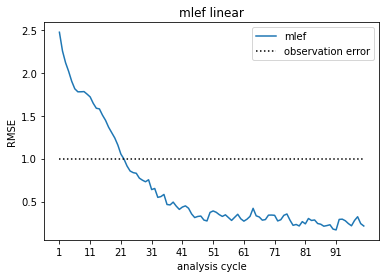

In [9]:
linecolor = {"mlef":'tab:blue',"grad":'tab:orange',"etkf":'tab:green', "po":'tab:red',\
        "srf":"tab:pink", "letkf":"tab:purple", "kf":"tab:cyan", "var":"tab:olive",\
        "var4d":"tab:brown"}
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e, color=linecolor[pt], label=pt)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()